## NLP Draft Predictions

This notebook details our first looks at the NHL prospects data which is a collection of 2014-2022 NHL player scouting reports from various public sports news outlets (e.g., The Athletic, EP Rinkside, ESPN).

Members:
- Quoc-Huy Nguyen
- Ryan DeSalvio



## Exploratory Data Analysis

In [38]:
import re
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize

import clean_reports
import preprocess_reports

from sentence_transformers import SentenceTransformer

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = clean_reports.clean(DATASET, raw=True)

data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,C,69.75,185.0,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,C,74.00,187.0,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,RW,70.00,148.0,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,C,75.00,194.0,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,LW,69.75,170.0,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               402 non-null    int64  
 1   Position                           402 non-null    object 
 2   Height                             402 non-null    float64
 3   Weight                             402 non-null    float64
 4   Drafted                            360 non-null    float64
 5   Team                               360 non-null    object 
 6   Average Ranking                    162 non-null    float64
 7   Name                               402 non-null    object 
 8   Description - Corey Pronman        389 non-null    object 
 9   Description - Scott Wheeler        213 non-null    object 
 10  Description - Smaht Scouting       149 non-null    object 
 11  Description - ESPN (Chris Peters)  229 non-null    object 

This visualization explores the accuracy/predictiveness of the `Average Ranking` feature in the dataset. **How well does `Average Ranking` predict the actual draft position?** We find that for the highly ranked players, the average ranking statistic seems pretty accurate as it follows well with a close resemblance to a 1-1 correspondence to the actual draft position (as indicated by conformance to the y=x line). However, for lower ranked players, there is more variation in their actual draft prediction (as shown by the spread and deviation from the y=x line).

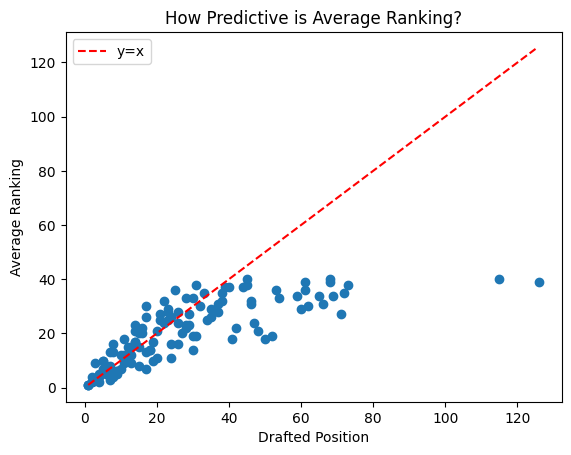

In [4]:
# define the y=x line for perfect alignment where the average
#   player ranking would have predicted the draft position
xx = np.arange(data['Drafted'].min(), data['Drafted'].max())
yy = xx

plt.scatter(data['Drafted'], data['Average Ranking'])
plt.plot(xx, yy, 'r--', label="y=x")
plt.xlabel("Drafted Position")
plt.ylabel("Average Ranking")
plt.legend()
plt.title("How Predictive is Average Ranking?")
plt.show()


From observing the count of non-missing values from the `Dataframe.info()` method, we may ask: **Why are there so many missing values for the `Average Ranking` feature?** After a bit of exploration, we find that scouting reports sourced prior to 2020 did not have this feature. 

In [5]:
mask = data['Average Ranking'].isnull()
for year, value in data[mask].groupby('Year').count().iloc[:,0].reset_index().to_numpy():
    print(f"For scouting reports with a missing value for `Average Ranking`, {value} come from {year}")

for year, value in data[~mask].groupby('Year').count().iloc[:,0].reset_index().to_numpy():
    print(f"For scouting reports with a value for `Average Ranking`, {value} come from {year}")

For scouting reports with a missing value for `Average Ranking`, 40 come from 2014
For scouting reports with a missing value for `Average Ranking`, 40 come from 2015
For scouting reports with a missing value for `Average Ranking`, 40 come from 2016
For scouting reports with a missing value for `Average Ranking`, 40 come from 2017
For scouting reports with a missing value for `Average Ranking`, 40 come from 2018
For scouting reports with a missing value for `Average Ranking`, 40 come from 2019
For scouting reports with a value for `Average Ranking`, 40 come from 2020
For scouting reports with a value for `Average Ranking`, 40 come from 2021
For scouting reports with a value for `Average Ranking`, 40 come from 2022
For scouting reports with a value for `Average Ranking`, 42 come from 2023


- Why is the `Average Ranking` feature encoded as a float type instead of an int type?
    - `Average Ranking` seems to be more appropriate as a int type, but we are not fully confident due to not knowing the method of computation for this feature. There is not a significant memory issue either.

In [6]:
data[~data['Average Ranking'].isnull()]['Average Ranking']

0       1.0
1       2.0
2       3.0
3       4.0
4       5.0
       ... 
157    36.0
158    37.0
159    38.0
160    39.0
161    40.0
Name: Average Ranking, Length: 162, dtype: float64

**What is the average scouting report length for each player? for each expert?**

In [7]:
# scouting report columns
mask = data.columns.str.match('Description')
scouting_reports = data.columns[mask]

# create a temporary DataFrame that stores the token length of each scouting 
#   report instead of the actual text
token_count_df = data.copy(deep=True)

for report in scouting_reports:
    token_count_df[report] = token_count_df[report].apply(
        lambda x: len(word_tokenize(x)) if isinstance(x,str) else np.nan
    )

In [8]:
# average scouting report for each expert
token_count_df[scouting_reports].mean().sort_values()


Description - EP Rinkside             89.803797
Description - The Painted Lines      146.406015
Description - ESPN (Chris Peters)    151.436681
Description - Corey Pronman          174.683805
Description - Smaht Scouting         239.865772
Description - Scott Wheeler          263.450704
Description - FCHockey               361.477143
Description - EP Rinkside Part 2     471.243386
dtype: float64

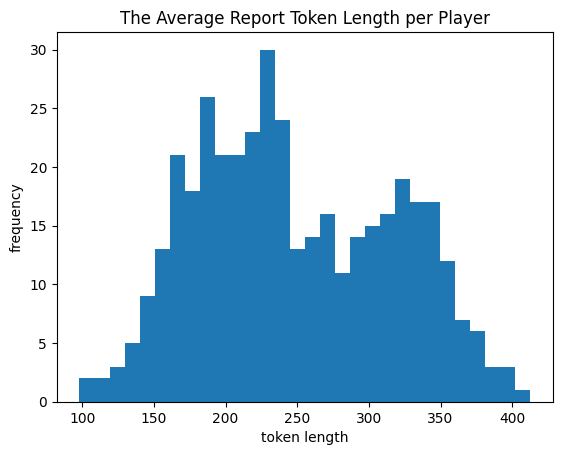

In [9]:
# average scouting report for each player
mean_token_length_per_player = pd.melt(
    token_count_df, 
    id_vars=['Name'], 
    value_vars=scouting_reports,
    var_name='scouting_report',
    value_name='token_count'
).groupby('Name')['token_count'].mean()

plt.hist(mean_token_length_per_player, bins=30)
plt.xlabel("token length")
plt.ylabel("frequency")
plt.title("The Average Report Token Length per Player")
plt.show()

In [39]:
bert_model = SentenceTransformer('all-mpnet-base-v2')

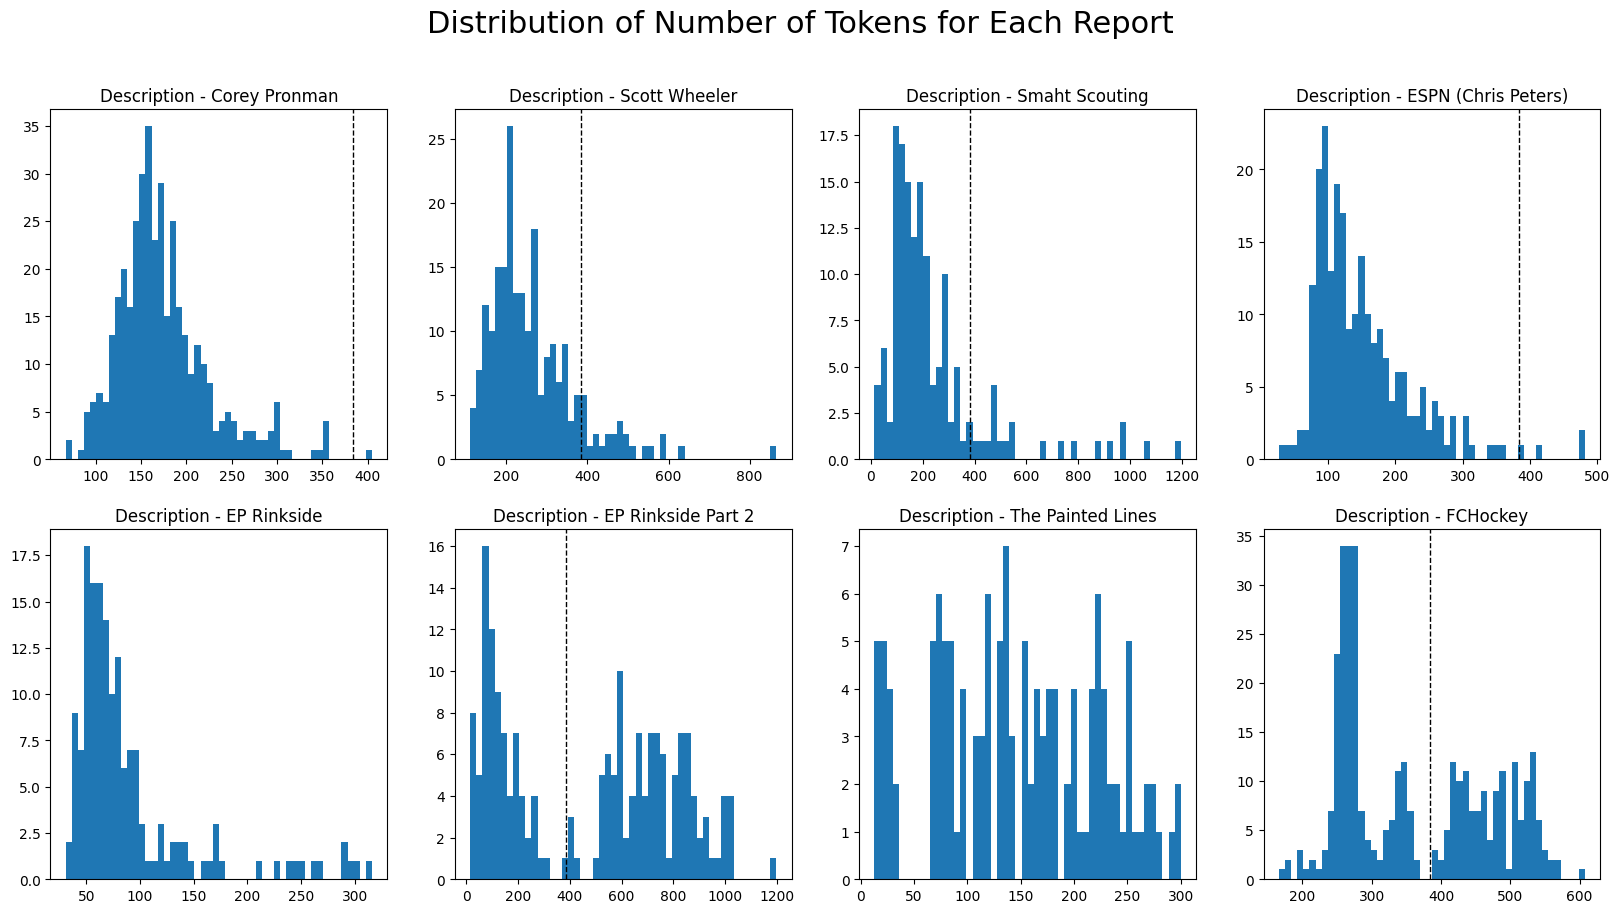

In [44]:
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
for index, report in enumerate(scouting_reports):
    xx = token_count_df[report].values
    i,j = [array[0] for array in np.unravel_index([index], shape=(nrows,ncols))]
    ax[i,j].hist(xx, bins=50)
    ax[i,j].set_title(report)

    # add a dotted vertical line
    if xx[~np.isnan(xx)].max() > bert_model.max_seq_length:
        ax[i,j].axvline(
            bert_model.max_seq_length, color='k', linestyle='dashed', linewidth=1
        )

plt.suptitle("Distribution of Number of Tokens for Each Report", fontsize=22)
plt.show()

In [11]:
# Check the length of each name
data['Name'].apply(len).sort_values()

218     8
238     8
311     9
142     9
305     9
       ..
8      20
49     20
227    20
33     21
264    21
Name: Name, Length: 402, dtype: int64

**Is there an unequal distribution between player positions? (e.g., a lot more forwards than defenders)**

In [12]:
# global variable that encodes the name of each hockey position
#   could be useful for visualization later on
HOCKEY_POSITIONS = {
    'C' : 'Center',
    'D' : 'Defender',
    'RW' : 'Right Wing',
    'LW' : 'Left Wing',
    'G' : 'Goalie'
}

# distribution of player positions
data['Position'].value_counts()

C     134
D     116
RW     78
LW     60
G      14
Name: Position, dtype: int64

<BarContainer object of 64 artists>

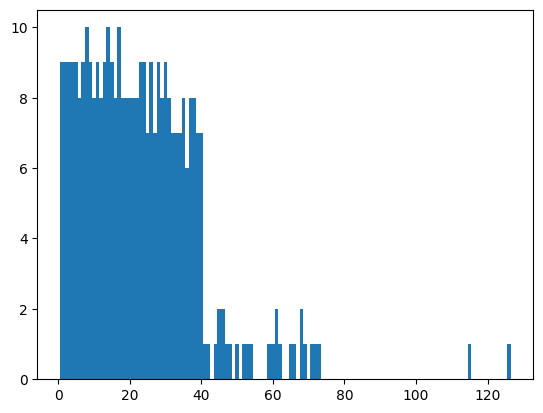

In [35]:
# check the histogram distribution of teams

# check the histogram distribution of draft position
x = data.groupby('Drafted').count().index
height = data.groupby('Drafted').count().iloc[:,0]
plt.bar(x, height,width=1.0)

## Data Cleaning

In [14]:
HOCKEY_WORDS = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "chl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "liiga", 
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna", "frolunda",
                "slovakia"]

# preprocess data with NLTK
preprocessed_df = data.copy()
for report in scouting_reports:
    report_preprocessor = preprocess_reports.NltkPreprocessor(data[report])
    preprocessed_df.loc[:,report] = report_preprocessor\
            .lower()\
            .remove_names(preprocessed_df['Name'])\
            .remove_whitespace()\
            .tokenize_text()\
            .remove_stopwords(HOCKEY_WORDS)\
            .normalize_words(normalization='porter')\
            .get_text()


In [15]:
preprocessed_df.head(5)

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,C,69.75,185.0,NaN,NaN,1.0,Connor Bedard,potenti franchise-chang . 1 prospect . skill s...,’ statist profil speak : 28 point 15 game 15-y...,extrem gift gener offens talent . whichev team...,"one natur gift goal scorer enter draft , much ...",NaN,premier prospect world . done unthink time tim...,NaN,NaN
1,2023,C,74.00,187.0,NaN,NaN,2.0,Adam Fantilli,"'s much love nhl project . ’ got huge frame , ...","big , strong , power take puck wall interior f...",everi tool nhl team would dream top overal sel...,"6-foot-2 , 200-pound power touch , kind player...",NaN,"fantast consol prize , would first overal sele...",NaN,NaN
2,2023,RW,70.00,148.0,NaN,NaN,3.0,Matvei Michkov,one best first-year draft elig 've ever seen i...,best prospect sinc alex ovechkin evgeni malkin...,"smart , dynam goal-scor winger , dictat play ’...","last year , ’ describ genius-level hockey play...",NaN,"statist , * anoth * first overal level prospec...",NaN,NaN
3,2023,C,75.00,194.0,NaN,NaN,4.0,Leo Carlsson,"elit skill , combin frame strong motor , allow...","though ’ play game shine three player front , ...",play extrem well level season örebro . offens ...,"buzz grow ( right ) belong top-tier draft , le...",NaN,"oh , look , anoth first-overal talent . shone ...",NaN,NaN
4,2023,LW,69.75,170.0,NaN,NaN,5.0,Zach Benson,ton creativ offens game . make high-end skill ...,"lot night last season , ice team boast half do...","’ necessarili see reach top superstar bucket ,...","offens dynamo deft score touch , key player on...",NaN,peopl worri select 5-9 forward without blaze s...,NaN,NaN


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09d8dc5c-d54b-4729-bd12-f4067dd931f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>